# Artificial Neural Networks and Deep Learning











---











# Homework 1

## ⚙️ Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.gridspec as gridspec
import keras
import keras_cv
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## ⏳ Load the Data

In [2]:
# Load Data
# data = np.load('clean_data.npz')
data = np.load("/kaggle/input/clean-data/clean_data.npz")
X = data["images"]
y = data["labels"]
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([ 852, 2181, 1085, 2026,  849,  993, 2330, 1643]))

In [3]:
# Labels dictionary
labels_dict = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

In [4]:
class_count = {}

for i in labels_dict:
    class_count[i] = np.unique(y, return_counts=True)[1][i]

class_count

{0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}

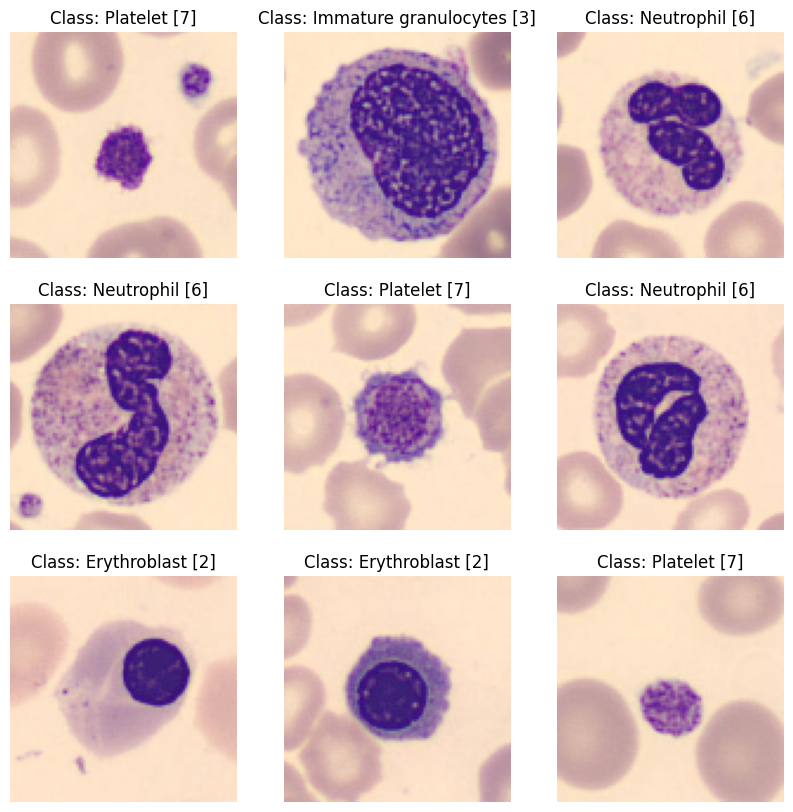

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.reshape((-1,))

for i in range(9):
    axs[i].imshow(X[i])
    axs[i].set_title(f"Class: {labels_dict[y[i][0]]} {y[i]}")
    axs[i].axis("off")


## 🔄 Process Data


In [6]:
# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

test_val_size = 0.05 # parameter to tune

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_val_size, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (10763, 96, 96, 3), y_train shape: (10763, 8)
X_val shape: (598, 96, 96, 3), y_val shape: (598, 8)
X_test shape: (598, 96, 96, 3), y_test shape: (598, 8)


## 🧮 Define Network Parameters


In [7]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [8]:
#Number of training epochs
epochs = 10 # parameter to tune

# Batch size for training
batch_size = 64 # parameter to tune

# Learning rate: step size for updating the model's weights
learning_rate = 0.001 # parameter to tune

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Epochs: 10
Batch Size: 64
Learning Rate: 0.001


## Data Augmentation

In [9]:
def random_augmentation(images):
    # Functions in here does not play with the labels, so we only get images as input
    # Define image size
    image_size = (96, 96)
    
    # Build the augmentation pipeline
    data_augmentation = keras_cv.layers.RandomAugmentationPipeline(
        layers=[
            keras_cv.layers.AutoContrast(value_range=(0, 1)),
            keras_cv.layers.JitteredResize(target_size=image_size, scale_factor=(0.8, 1.2)),
            keras_cv.layers.RandomColorDegeneration(factor=0.5),
            keras_cv.layers.RandomHue(factor=0.2, value_range=(0, 1)),
            keras_cv.layers.RandomSaturation(factor=0.3),
            keras_cv.layers.RandomSharpness(factor=0.3, value_range=(0, 1)),
            keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2),
            keras_cv.layers.Solarization(value_range=(0, 1)),
            keras_cv.layers.AugMix(value_range=(0, 1)),
            keras_cv.layers.ChannelShuffle(groups=3),
            keras_cv.layers.GridMask(),
            keras_cv.layers.RandomChannelShift(factor=0.1, value_range=(0, 1)),
            keras_cv.layers.RandomCutout(width_factor=0.3, height_factor=0.3),
        ],
        augmentations_per_image=3
    )
    return data_augmentation(images)

def cutMix(images, labels):
    # Define the CutMix augmentation layer
    cutmix = keras_cv.layers.CutMix()
    
    # Convert to TensorFlow tensors and ensure both images and labels are float32
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(np.array(labels, dtype=np.float32))  
    
    # Apply CutMix
    output = cutmix({"images": images, "labels": labels})
    cutmix_images=output['images']
    cutmix_labels=output['labels']
    
    return cutmix_images, cutmix_labels


def fourierMix(images, labels):
    # Define the FourierMix augmentation layer
    cutmix = keras_cv.layers.FourierMix(0.5)
    
    # Convert to TensorFlow tensors and ensure both images and labels are float32
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(np.array(labels, dtype=np.float32))  
    
    # Apply FourierMix
    output = cutmix({"images": images, "labels": labels})
    fouriermix_images=output['images']
    fouriermix_labels=output['labels']
    
    return fouriermix_images, fouriermix_labels


def mixUp(images, labels):
    # Define the mixUp augmentation layer
    cutmix = keras_cv.layers.MixUp(10)
    
    # Convert to TensorFlow tensors and ensure both images and labels are float32
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(np.array(labels, dtype=np.float32))  
    
    # Apply MixUp
    output = cutmix({"images": images, "labels": labels})
    mixup_images=output['images']
    mixup_labels=output['labels']
    
    return mixup_images, mixup_labels    

In [10]:
def total_augmentation(images, labels):
    # We don't want to mix all the random augmentations with cutMix, FourierMix and MixUp so we will apply some combinations
    # In the end, we will have the following data in our dataset:
    # 1. Clean data
    # 2. Clean + Random augmentation data
    # 3. Clean + cutMix
    # 4. Clean + FourierMix
    # 5. Clean + mixUp
    # 6. Clean + Random augmentation data + cutMix

    random_aug = random_augmentation(images)
    cutmix_images, cutmix_labels = cutMix(images, labels)
    fourier_images, fourier_labels = fourierMix(images, labels)
    mixup_images, mixup_labels = mixUp(images, labels)
    aug_cutmix_images, aug_cutmix_labels = cutMix(random_aug, labels)
    
    # Combine all the data
    
    #total_aug_images = tf.concat([images, random_aug, cutmix_images, mixup_images], axis=0)
    #total_aug_labels = tf.concat([labels, labels, cutmix_labels, mixup_labels], axis=0)
    total_aug_images = tf.concat([images, random_aug, cutmix_images, fourier_images, mixup_images, aug_cutmix_images], axis=0)
    total_aug_labels = tf.concat([labels, labels, cutmix_labels, fourier_labels, mixup_labels, aug_cutmix_labels], axis=0)
    
    del random_aug
    del cutmix_images
    del cutmix_labels
    del mixup_images
    del mixup_labels
    
    return total_aug_images, total_aug_labels

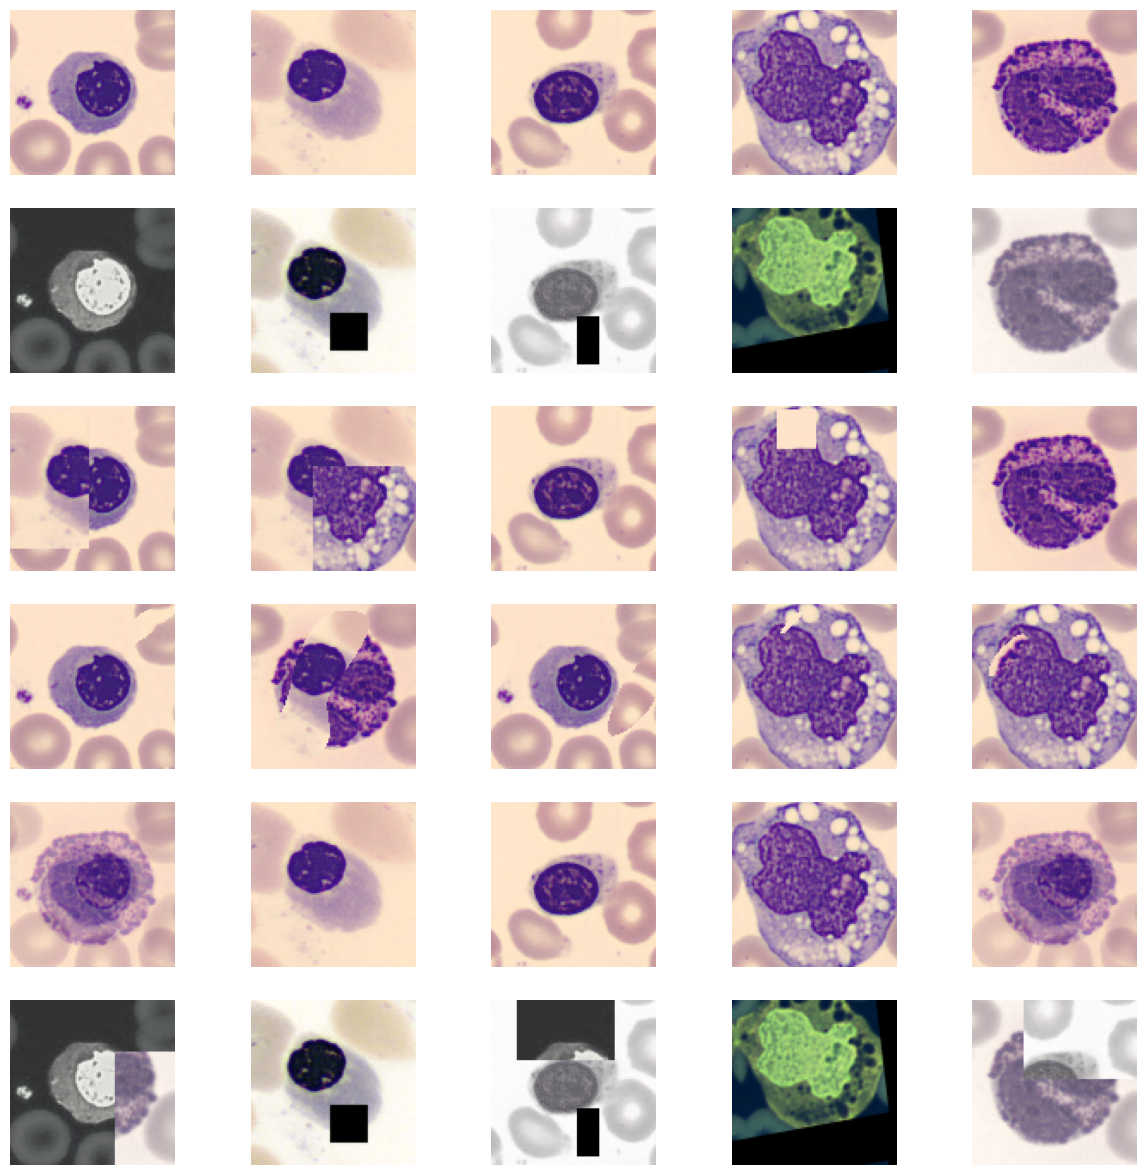

In [11]:
# Let's visualize the augmentation with 5 images
sample_images = X_train[:5]  # Replace with your actual image data, assuming it’s a NumPy array or tf.Tensor
sample_labels = y_train[:5]

sample_aug_images, sample_aug_labels = total_augmentation(sample_images, sample_labels)

# Visualize sample augmentations
fig, axs = plt.subplots(6, 5, figsize=(15, 15))
axs = axs.reshape((-1,))
for i in range(30):
    axs[i].imshow(sample_aug_images[i])
    axs[i].axis("off")


In [12]:
# Now, let's apply this to the whole dataset!
aug_images, aug_labels = total_augmentation(X_train, y_train)

ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_6_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[64578,96,96,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [ ]:
images, labels = X_train, y_train
random_aug = random_augmentation(images)

In [ ]:
# Combine all the data
total_aug_images = tf.concat([images, random_aug], axis=0)
total_aug_labels = tf.concat([labels, labels], axis=0)

del random_aug

## 🛠️ Build the Model

In [ ]:
model_large = keras.applications.ConvNeXtXLarge(
    include_top=False, #can change this
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling="avg", #can change this
    classes=8,
    classifier_activation="softmax"    
)
tfk.utils.plot_model(model_large, show_shapes=True)

In [ ]:
model_large.trainable = False #Freeze the weights of the CNN
tf.random.set_seed(seed)

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
], name='Augmentation')

x = augmentation(inputs)

# Connect ConvNeXtXLarge to the input
x = model_large(x)

###################################################################################################
# Adding additional layers here
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(512, activation='relu', name='dense1')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(256, activation='relu', name='dense2')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(128, activation='relu', name='dense3')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)
###################################################################################################
# Add a Dense layer with 8 units and softmax activation as the classifier
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate), metrics=['accuracy'])

# Display a summary of the model architecture
model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ Train and Save the Model

In [ ]:
# Define the patience value for early stopping
patience = 10 # parameter to tune

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=patience, min_lr=1e-6, verbose=1
)
# Store the callback in a list
callbacks = [early_stopping, reduce_lr]

In [ ]:
total_aug_images.shape,total_aug_labels.shape

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=total_aug_images*255, #The model takes inputs in the range 0-255 
    y=total_aug_labels,
    batch_size=batch_size,
    epochs=5,
    validation_data=(X_val*255, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_large.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

In [ ]:
# Plot training and validation loss

plt.figure(figsize=(15, 2))
plt.plot(history["loss"], label="Training loss", alpha=0.8)
plt.plot(history["val_loss"], label="Validation loss", alpha=0.8)
plt.title("Loss")
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history["accuracy"], label="Training accuracy", alpha=0.8)
plt.plot(history["val_accuracy"], label="Validation accuracy", alpha=0.8)
plt.title("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [ ]:
# Load the saved model
# model = tfk.models.load_model('cell.keras')

model = tfk.models.load_model('/kaggle/working/model_large.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

In [ ]:
# Predict class probabilities and get predicted classes

test_predictions = model.predict(X_test*255, verbose=0)
print(len(test_predictions))
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f"Accuracy score over the test set: {round(test_accuracy, 4)}")

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average="weighted")
print(f"Precision score over the test set: {round(test_precision, 4)}")

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average="weighted")
print(f"Recall score over the test set: {round(test_recall, 4)}")

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average="weighted")
print(f"F1 score over the test set: {round(test_f1, 4)}")

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    xticklabels=list(labels_dict.values()),
    yticklabels=list(labels_dict.values()),
    cmap="Blues",
)

plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()

## 🛠️ Fine Tuning

In [ ]:
# Re-load the model after transfer learning

ft_model = tfk.models.load_model('/kaggle/input/model_large_aug2/keras/default/1/model_large.keras')



# Display a summary of the model architecture

ft_model.summary(expand_nested=True)



# Display model architecture with layer shapes and trainable parameters

tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Set the ConvNeXtXLarge model layers as trainable

ft_model.get_layer('convnext_xlarge').trainable = True



# Set all ConvNeXtXLarge layers as non-trainable

for layer in ft_model.get_layer('convnext_xlarge').layers:

    layer.trainable = False



# Enable training only for Conv2D and DepthwiseConv2D layers

for i, layer in enumerate(ft_model.get_layer('convnext_xlarge').layers):

    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):

        layer.trainable = True

        print(i, layer.name, type(layer).__name__, layer.trainable)

In [ ]:
# Set the number of layers to freeze

N = 124



# Set the first N layers as non-trainable

for i, layer in enumerate(ft_model.get_layer('convnext_xlarge').layers[:N]):

    layer.trainable = False



# Print layer indices, names, and trainability status

for i, layer in enumerate(ft_model.get_layer('convnext_xlarge').layers):

    print(i, layer.name, layer.trainable)



# Display a summary of the model architecture

ft_model.summary(expand_nested=True)



# Display model architecture with layer shapes and trainable parameters

tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Compile the model

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
# Fine-tune the model

ft_history = ft_model.fit(

    x=total_aug_images*255, #The model takes inputs in the range 0-255 
    y=total_aug_labels,
    batch_size=batch_size,
    epochs=5,
    validation_data=(X_val*255, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]

).history



# Calculate and print the final validation accuracy

final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')



# Save the trained model to a file with the accuracy included in the filename

model_filename = 'ft_model_large_'+str(final_val_accuracy)+'.keras'

ft_model.save(model_filename)

In [ ]:
# Predict class probabilities and get predicted classes

test_predictions = ft_model.predict(X_test*255, verbose=0)
print(len(test_predictions))
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f"Accuracy score over the test set: {round(test_accuracy, 4)}")

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average="weighted")
print(f"Precision score over the test set: {round(test_precision, 4)}")

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average="weighted")
print(f"Recall score over the test set: {round(test_recall, 4)}")

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average="weighted")
print(f"F1 score over the test set: {round(test_f1, 4)}")

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    xticklabels=list(labels_dict.values()),
    yticklabels=list(labels_dict.values()),
    cmap="Blues",
)

plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()


# Delete the model to free up resources

del ft_model

## 📊 Prepare Your Submission


To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:


```python

# file: model.py

class Model:

    def __init__(self):


        """Initialize the internal state of the model."""


    def predict(self, X):


        """Return a numpy array with the labels corresponding to the input X."""

```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.


❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:

    def __init__(self):

        """

        Initialize the internal state of the model. Note that the __init__

        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained

        model.

        """

        self.neural_network = tfk.models.load_model('ft_model_large.keras')


    def predict(self, X):

        """

        Predict the labels corresponding to the input X. Note that X is a numpy

        array of shape (n_samples, 96, 96, 3) and the output should be a numpy

        array of shape (n_samples,). Therefore, outputs must no be one-hot

        encoded.

        The following is an example of a prediction from the pre-trained model

        loaded in the __init__ method.

        """

        preds = self.neural_network.predict(X, verbose=0)

        # Get the predicted classes, not the one-hot encoded values
        preds = np.argmax(preds, axis=-1)

        return preds


In [ ]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py model_large.keras

# from google.colab import files
# files.download(filename)

In [ ]:
filename